# Battery Voltage Prediction Model

This notebook demonstrates a predictive modeling approach for estimating battery voltage in a spacecraft battery using telemetry data. We utilize LSTM neural networks and custom feature engineering methods to capture the dependencies in the data, aiming to achieve high accuracy in voltage predictions.

### Importing Required Libraries and Setting Up the Environment

We start by importing necessary libraries for data handling, model building, and visualization. Additionally, we configure the environment to suppress TensorFlow warnings for a cleaner output.

In [ ]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
from dynamic_timeseries_dashboard_new import get_telemetry_data, ElasticsearchCloudQuery
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppresses INFO (1), WARNING (2), and ERROR (3)
import tensorflow as tf
tf.get_logger().setLevel('ERROR')


/home/ybondo/anaconda3/envs/jupytersb/lib/python3.11/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


### Data Acquisition and Preprocessing

In this section, we connect to our Elasticsearch data source to fetch telemetry data for the specified spacecraft and time period. The telemetry data includes various parameters such as battery voltage, current, solar array current, and ADCS (Attitude Determination and Control System) states, among others.

In [ ]:
import numpy as np
import pandas as pd
import pendulum

# Pull telemetry data (same as before)
telemetry_puller = ElasticsearchCloudQuery(context='telemetry', environment='prod', debug=False)
spacecraft_id = '105'
start_time = pendulum.parse('2024-10-13T07:00:00Z')
end_time = pendulum.parse('2024-10-22T14:00:00Z')
# start_time = pendulum.parse('2024-10-19T07:00:00Z')
# end_time = pendulum.parse('2024-10-19T14:00:00Z')


# Define telemetry points to pull
telemetry_points = [
    'spacecraft_eps_pcu_batteryVoltage',
    'spacecraft_eps_pcu_loadCurrent',
    'spacecraft_eps_pcu_solarArrayCurrent',
    'spacecraft_adcs_afswOut_acMode',
    'spacecraft_adcs_afswOut_eclipseCondition',
    'spacecraft_adcs_afswOut_betaAngle',
    # 'spacecraft_eps_pcu_batteryATemp1',
    # 'spacecraft_eps_pcu_batteryATemp2',
    # 'spacecraft_eps_pcu_batteryATemp3',
    # 'spacecraft_eps_pcu_batteryBTemp1',
    # 'spacecraft_eps_pcu_batteryBTemp2',
    # 'spacecraft_eps_pcu_batteryBTemp3'
]

# Fetch data from Elasticsearch
df_ = get_telemetry_data(
    telemetry_puller=telemetry_puller, 
    spacecraft_id=spacecraft_id, 
    start=start_time, 
    end=end_time, 
    telemetry_points=telemetry_points, 
    debug=True
)

print(df_.head(0))

Using cached telemetry data
Empty DataFrame
Columns: [spacecraft_eps_pcu_batteryVoltage, spacecraft_eps_pcu_loadCurrent, spacecraft_eps_pcu_solarArrayCurrent, spacecraft_adcs_afswOut_acMode, spacecraft_adcs_afswOut_eclipseCondition, spacecraft_adcs_afswOut_betaAngle]
Index: []


### Data Transformation and Feature Engineering

To enhance our model's predictive capabilities, we engineer new features from the raw telemetry data:
1. **Battery Current Calculation**: Computed as the difference between load and solar array current.
2. **Suntrack Condition**: Created as a binary feature to indicate suntracking (based on ADCS mode).
3. **Fractional Orbit Calculation**: Derived from eclipse condition data to represent the spacecraft's position within an orbit.
4. **Smoothing**: We apply the Savitzky-Golay filter for noise reduction in battery current and voltage measurements.


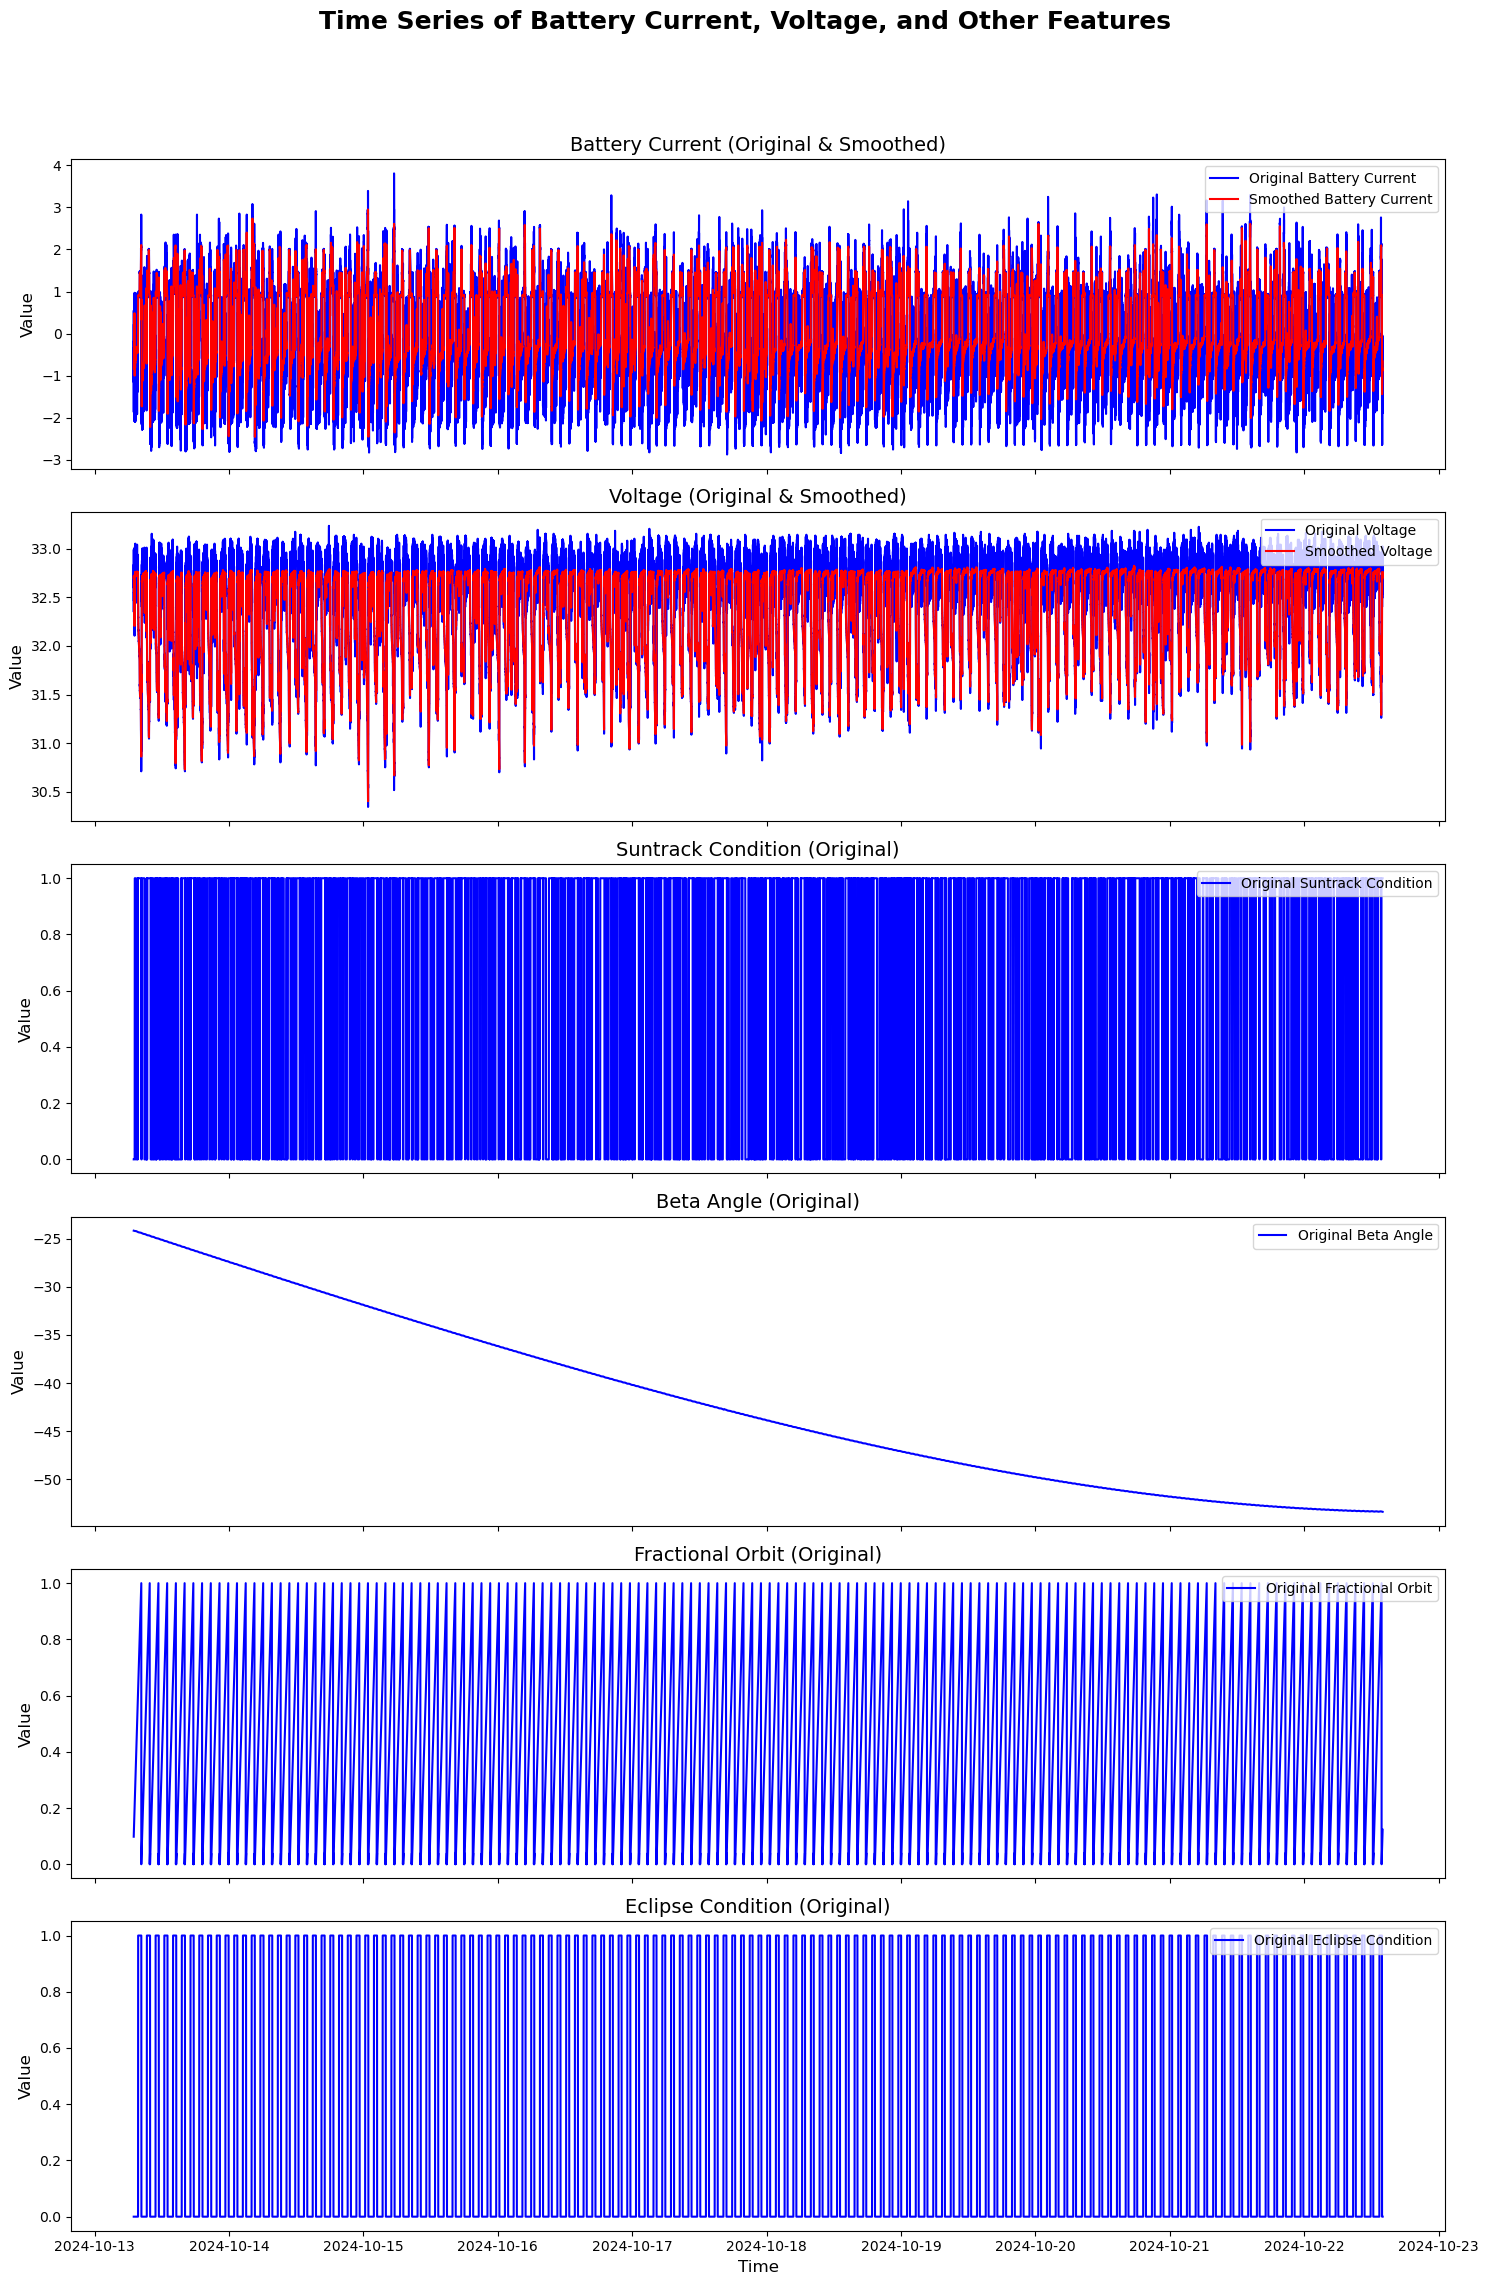

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Define default orbit period (90 minutes = 5400 seconds)
orbit_period = 5400  # in seconds

# 1. Calculate Battery Current (loadCurrent - solarArrayCurrent)
df_['battery_current'] = df_['spacecraft_eps_pcu_loadCurrent'] - df_['spacecraft_eps_pcu_solarArrayCurrent']

# 2. Simplify Temperature (Retain only extreme trends)
# temperature_columns = [
#     'spacecraft_eps_pcu_batteryATemp1', 'spacecraft_eps_pcu_batteryATemp2', 'spacecraft_eps_pcu_batteryATemp3',
#     'spacecraft_eps_pcu_batteryBTemp1', 'spacecraft_eps_pcu_batteryBTemp2', 'spacecraft_eps_pcu_batteryBTemp3'
# ]

# Calculate the midpoint temperature for each row
# df_['temp_midpoint'] = df_[temperature_columns].mean(axis=1)

# For each row, retain the highest temperature if it's above the midpoint, and the lowest if it's below
# df_['temperature'] = np.where(df_[temperature_columns].max(axis=1) > df_['temp_midpoint'],
#                               df_[temperature_columns].max(axis=1),
#                               df_[temperature_columns].min(axis=1))

# 3. Create Suntrack Condition (acMode == 5 => suntracking)
df_['suntrack_condition'] = np.where(df_['spacecraft_adcs_afswOut_acMode'] == 5, 1, 0)

# 4. Retain Eclipse Condition (already in telemetry)
df_['eclipse_condition'] = df_['spacecraft_adcs_afswOut_eclipseCondition']

# 5. Calculate Fractional Orbit
# Prepare eclipse exit times and add 'fractional_orbit' column
df_['fractional_orbit'] = np.nan
eclipse_exits = df_[(df_['spacecraft_adcs_afswOut_eclipseCondition'] == 0) & 
                    (df_['spacecraft_adcs_afswOut_eclipseCondition'].shift(1) == 1)].index

# Precompute the next and last eclipse exits for each timestamp, ensuring they are within bounds
next_exit_idx = np.minimum(eclipse_exits.searchsorted(df_.index, side='right'), len(eclipse_exits) - 1)
last_exit_idx = np.maximum(0, next_exit_idx - 1)  # Ensure index doesn't go below zero

# Fetch next and last eclipse exits while handling cases where indices may be out of range
next_eclipse_exit = eclipse_exits[next_exit_idx].to_series(index=df_.index, name='next_exit')
last_eclipse_exit = eclipse_exits[last_exit_idx].to_series(index=df_.index, name='last_exit')

# Calculate time since and until eclipse exit in seconds using vectorized .dt.total_seconds()
time_since_last_exit = (df_.index.to_series() - last_eclipse_exit).dt.total_seconds()
time_until_next_exit = (next_eclipse_exit - df_.index.to_series()).dt.total_seconds()

# Use np.where to assign fractional orbit with vectorized conditions
df_['fractional_orbit'] = np.where(
    pd.notna(time_since_last_exit),
    (time_since_last_exit % orbit_period) / orbit_period,
    np.where(
        pd.notna(time_until_next_exit),
        1 - (time_until_next_exit % orbit_period) / orbit_period,
        0
    )
)

# Forward-fill NaN values in fractional_orbit to replace with last valid value
df_['fractional_orbit'] = df_['fractional_orbit'].ffill()

# Apply Savitzky-Golay filter to smooth only battery current and voltage
def smooth_feature(series, window_length=60, poly_order=1):
    if len(series) < window_length:
        window_length = len(series) - (1 - len(series) % 2)  # Ensure window length is odd and <= data length
    return savgol_filter(series, window_length=window_length, polyorder=poly_order)

# Smooth specific features
df_['smoothed_battery_current'] = smooth_feature(df_['battery_current'], window_length=120, poly_order=1)
df_['smoothed_voltage'] = smooth_feature(df_['spacecraft_eps_pcu_batteryVoltage'])

# Function to plot time series subplots
def plot_time_series_subplots(df, features, titles, title="Feature Time Series", zoom=False, start_time=None, end_time=None):
    # Select time index and features based on zoom range
    time_index = df.index
    if zoom and start_time is not None and end_time is not None:
        # Apply time range filter
        mask = (time_index >= start_time) & (time_index <= end_time)
        df = df[mask]
        time_index = df.index
    
    num_features = len(features)
    
    # Set up subplots
    fig, axes = plt.subplots(num_features, 1, figsize=(15, 4 * num_features), sharex=True)
    fig.suptitle(title, fontsize=18, fontweight='bold')

    for i, feature in enumerate(features):
        original_data = df[feature]
        # Plot original data
        axes[i].plot(time_index, original_data, label=f'Original {titles[i]}', linestyle='-', color='blue')
        
        # Plot smoothed data if feature matches
        if feature == 'battery_current':
            axes[i].plot(time_index, df['smoothed_battery_current'], label='Smoothed Battery Current', linestyle='-', color='red')
        elif feature == 'spacecraft_eps_pcu_batteryVoltage':
            axes[i].plot(time_index, df['smoothed_voltage'], label='Smoothed Voltage', linestyle='-', color='red')
        
        # Customizations
        axes[i].set_title(f'{titles[i]} (Original{" & Smoothed" if feature in ["battery_current", "spacecraft_eps_pcu_batteryVoltage"] else ""})', fontsize=14)
        axes[i].legend(loc='upper right')
    
    # Set font size for x-axis and y-axis labels
    for ax in axes:
        ax.set_ylabel('Value', fontsize=12)
    axes[-1].set_xlabel('Time', fontsize=12)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Define features and their display titles
features = [
    'battery_current', 
    'spacecraft_eps_pcu_batteryVoltage', 
    'suntrack_condition', 
    'spacecraft_adcs_afswOut_betaAngle', 
    'fractional_orbit', 
    'eclipse_condition'
]
titles = [
    'Battery Current', 
    'Voltage', 
    'Suntrack Condition', 
    'Beta Angle', 
    'Fractional Orbit', 
    'Eclipse Condition'
]

# Uncomment to plot all main features
plot_time_series_subplots(df_, features, titles, title="Time Series of Battery Current, Voltage, and Other Features")


In [ ]:
# plot_time_series_subplots(df_, features, titles, title="Time Series of Battery Current, Voltage, and Other Features", zoom=True, start_time='2024-10-19T07:00:00Z' , end_time='2024-10-19T08:00:00Z' )

### Data Scaling and Preparation for Modeling

In this step, we scale the features to ensure consistent value ranges, which aids in model convergence during training. The target variable is battery voltage, while the input features include battery current, suntrack condition, beta angle, and more.


In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Apply Savitzky-Golay filter to smooth 'battery_current' and 'voltage'
df_['Battery Current'] = smooth_feature(df_['spacecraft_eps_pcu_loadCurrent'] - df_['spacecraft_eps_pcu_solarArrayCurrent'])
df_['Battery Voltage'] = smooth_feature(df_['spacecraft_eps_pcu_batteryVoltage'])

# # Compute rate of change for Battery Current
# df_['current_rate_of_change'] = df_['Battery Current'].diff()

# # Fill any NaN values that might be introduced (e.g., the first row)
# df_['current_rate_of_change'] = df_['current_rate_of_change'].fillna(0)


# Rename other telemetry points for clarity
df_.rename(columns={
    'suntrack_condition': 'Suntrack Condition',
    'spacecraft_adcs_afswOut_betaAngle': 'Beta Angle',
    # 'temperature': 'Temperature',
    'eclipse_condition': 'Eclipse Condition',
    'fractional_orbit': 'Fractional Orbit'
}, inplace=True)

# Include the new feature in the scaling process
features_to_scale = ['Battery Current', 'Battery Voltage', 'Suntrack Condition', 
                     'Beta Angle', 'Eclipse Condition', 
                     'Fractional Orbit']

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_[features_to_scale])

# Convert scaled data to DataFrame for consistency
scaled_df = pd.DataFrame(scaled_features, columns=features_to_scale, index=df_.index)

# Update the feature set (X)
X = scaled_df.drop(columns=['Battery Voltage']).to_numpy()  # Voltage remains as the label (y)
y = scaled_df['Battery Voltage'].to_numpy()

# Split data into training, validation, and test sets
num_data = len(X)
train_size = int(0.6 * num_data)
val_size = int(0.2 * num_data)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Define preprocessing function for TensorFlow model
def preprocess_data(X, y, window_size=1, batch_size=1032, shuffle_buffer=10000):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda x, y: tf.data.Dataset.zip((x.batch(window_size + 1), y.batch(window_size + 1))))
    dataset = dataset.map(lambda x, y: (x[:-1], y[-1]))
    dataset = dataset.shuffle(shuffle_buffer).batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)
    return dataset

# Create datasets
train_dataset = preprocess_data(X_train, y_train)
val_dataset = preprocess_data(X_val, y_val)
test_dataset = preprocess_data(X_test, y_test)

# Verify batch shapes
for x_batch, y_batch in train_dataset.take(1):
    print("X batch shape:", x_batch.shape)
    print("Y batch shape:", y_batch.shape)


X batch shape: (1032, 1, 5)
Y batch shape: (1032,)


In [ ]:
batch_size = 1032
desired_steps_train = X_train.shape[0]//batch_size
desired_steps_val = X_val.shape[0]//batch_size
warmup_epochs = 1  # typically 1-5 epochs is common
warmup_steps = desired_steps_train * warmup_epochs
print(desired_steps_train, f"\n{desired_steps_val}\n{warmup_steps}")

466 
155
466


## Model Architecture: Residual and Dense Blocks

The model leverages a combination of Residual CNN layers and Dense layers with residual connections. This architecture helps to capture temporal dependencies and improve model performance.
- **Residual CNN Blocks**: Capture localized patterns in the input sequence.
- **LSTM Layers**: Capture long-term dependencies in the sequential data.
- **Dense Layers**: Provide additional complexity and allow for nonlinear combinations of features.


In [ ]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size=3):
        super(ResidualBlock, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv1D(filters, kernel_size=kernel_size, padding='same', kernel_initializer='he_normal')
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv1D(filters, kernel_size=kernel_size, padding='same', kernel_initializer='he_normal')
        self.adjust_channels = None

    def build(self, input_shape):
        if input_shape[-1] != self.filters:
            self.adjust_channels = tf.keras.layers.Conv1D(self.filters, kernel_size=1, padding='same', kernel_initializer='he_normal')
        super(ResidualBlock, self).build(input_shape)

    def call(self, x):
        residual = self.adjust_channels(x) if self.adjust_channels else x
        x = self.batch_norm1(x)
        x = tf.keras.activations.relu(x)
        x = self.conv1(x)
        x = self.batch_norm2(x)
        x = tf.keras.activations.relu(x)
        x = self.conv2(x)
        return tf.keras.layers.add([x, residual])

    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
            "kernel_size": self.kernel_size,
        })
        return config


class ResidualDenseBlock(tf.keras.layers.Layer):
    def __init__(self, units, activation='relu', kernel_regularizer=None):
        super(ResidualDenseBlock, self).__init__()
        self.units = units
        self.activation = activation
        self.kernel_regularizer = kernel_regularizer
        
        # First dense layer
        self.dense1 = tf.keras.layers.Dense(units, activation=activation, kernel_regularizer=kernel_regularizer, 
                                            kernel_initializer='he_normal')
        # Second dense layer
        self.dense2 = tf.keras.layers.Dense(units, activation=None, kernel_regularizer=kernel_regularizer, 
                                            kernel_initializer='he_normal')
        
        # Layer normalization to ensure stable training
        self.layer_norm1 = tf.keras.layers.LayerNormalization()
        self.layer_norm2 = tf.keras.layers.LayerNormalization()
        
        # Define a linear layer to adjust input dimensions if necessary
        self.adjust_channels = None

    def build(self, input_shape):
        if input_shape[-1] != self.units:
            self.adjust_channels = tf.keras.layers.Dense(self.units, activation=None)
        super(ResidualDenseBlock, self).build(input_shape)

    def call(self, x):
        residual = self.adjust_channels(x) if self.adjust_channels else x
        
        # Pass through first dense layer and apply layer norm
        x = self.dense1(x)
        x = self.layer_norm1(x)
        x = tf.keras.activations.relu(x)
        
        # Pass through second dense layer and apply layer norm
        x = self.dense2(x)
        x = self.layer_norm2(x)
        
        # Add the residual connection (skip connection)
        return tf.keras.layers.add([x, residual])

    def get_config(self):
        config = super().get_config()
        config.update({
            "units": self.units,
            "activation": self.activation,
            "kernel_regularizer": self.kernel_regularizer,
        })
        return config


model = tf.keras.Sequential([
    # Input layer with fixed time steps based on your window_size
    tf.keras.layers.Input(shape=(1, 5)),  # Adjust the first dimension to match your window_size
    
    # Improved Residual CNN blocks
    ResidualBlock(filters=64, kernel_size=3),
    ResidualBlock(filters=64, kernel_size=3),
    
    tf.keras.layers.SpatialDropout1D(0.1),
    
    # Fixed LSTM layers without unroll
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, 
        return_sequences=True,
        recurrent_initializer='orthogonal',
        recurrent_regularizer=tf.keras.regularizers.l2(1e-5),
        recurrent_dropout=0.1)),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,
        return_sequences=True,
        recurrent_initializer='orthogonal',
        recurrent_regularizer=tf.keras.regularizers.l2(1e-5),
        recurrent_dropout=0.1)),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,
        return_sequences=False,
        recurrent_initializer='orthogonal',
        recurrent_regularizer=tf.keras.regularizers.l2(1e-5),
        recurrent_dropout=0.1)),
    
    tf.keras.layers.LayerNormalization(),
    
    # Dense layers remain the same
    ResidualDenseBlock(units=256, activation='selu',
                      kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    tf.keras.layers.Dropout(0.2),
    
    ResidualDenseBlock(units=128, activation='selu',
                      kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(64, activation='selu',
                         kernel_regularizer=tf.keras.regularizers.l2(0.0005),
                         kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(32, activation='selu',
                         kernel_regularizer=tf.keras.regularizers.l2(0.0005),
                         kernel_initializer='lecun_normal'),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Dense(1, activation='linear')
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=desired_steps_train,
    decay_rate=0.95,
    staircase=True
)


# Compile with improved settings
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=lr_schedule,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7,
        clipnorm=1.0  # Add gradient clipping
    ),
    loss=tf.keras.losses.Huber(delta=1.0),
    metrics=['mse', 'mae']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ residual_block (ResidualBlock)  │ (None, 1, 64)          │        14,036 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_1                │ (None, 1, 64)          │        25,216 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 1, 64)          │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 1, 256)         │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 256)            │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_dense_block            │ (None, 256)            │       132,608 │
│ (ResidualDenseBlock)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_dense_block_1          │ (None, 128)            │        82,816 │
│ (ResidualDenseBlock)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,251,669 (4.77 MB)

 Trainable params: 1,251,275 (4.77 MB)

 Non-trainable params: 394 (1.54 KB)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        min_delta=1e-4,
        verbose=1
    )
]

history = model.fit(train_dataset, validation_data=val_dataset, steps_per_epoch=desired_steps_train, 
                    validation_steps=desired_steps_val, epochs=100, callbacks=callbacks)


Epoch 1/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 106s 196ms/step - loss: 0.8544 - mae: 0.4938 - mse: 0.7618 - val_loss: 0.2813 - val_mae: 0.2277 - val_mse: 0.1254
Epoch 2/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 120s 259ms/step - loss: 0.2024 - mae: 0.1826 - mse: 0.0618 - val_loss: 0.1176 - val_mae: 0.2087 - val_mse: 0.0730
Epoch 3/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 121s 260ms/step - loss: 0.0924 - mae: 0.1587 - mse: 0.0489 - val_loss: 0.0835 - val_mae: 0.2001 - val_mse: 0.0865
Epoch 4/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 131s 282ms/step - loss: 0.0566 - mae: 0.1454 - mse: 0.0422 - val_loss: 0.0561 - val_mae: 0.1497 - val_mse: 0.0631
Epoch 5/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 130s 279ms/step - loss: 0.0423 - mae: 0.1402 - mse: 0.0396 - val_loss: 0.0557 - val_mae: 0.1799 - val_mse: 0.0765
Epoch 6/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 119s 257ms/step - loss: 0.0354 - mae: 0.1365 - mse: 0.0376 - val_loss: 0.0729 - val_mae: 0.2074 - val_mse: 0.1179
Epoch 7/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 124s 268ms/step - loss: 0.031

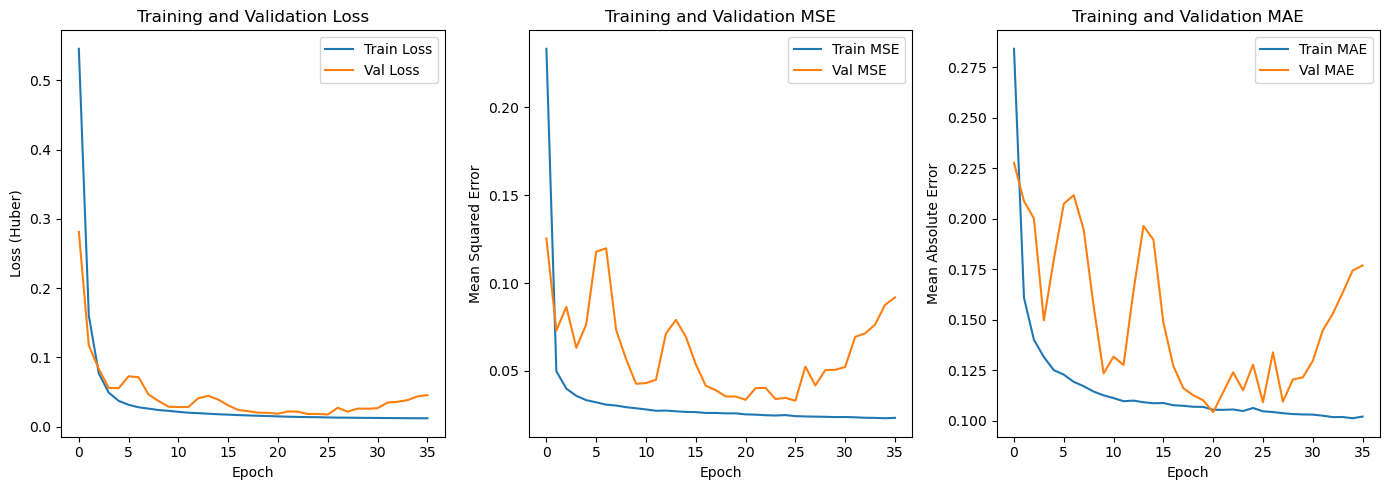

In [ ]:
# Plot training history for loss, mse, and mae
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Huber)')
plt.title('Training and Validation Loss')
plt.legend()

# Mean Squared Error plot
plt.subplot(1, 3, 2)
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation MSE')
plt.legend()

# Mean Absolute Error plot
plt.subplot(1, 3, 3)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Training and Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

15053/15053 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step
5018/5018 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step


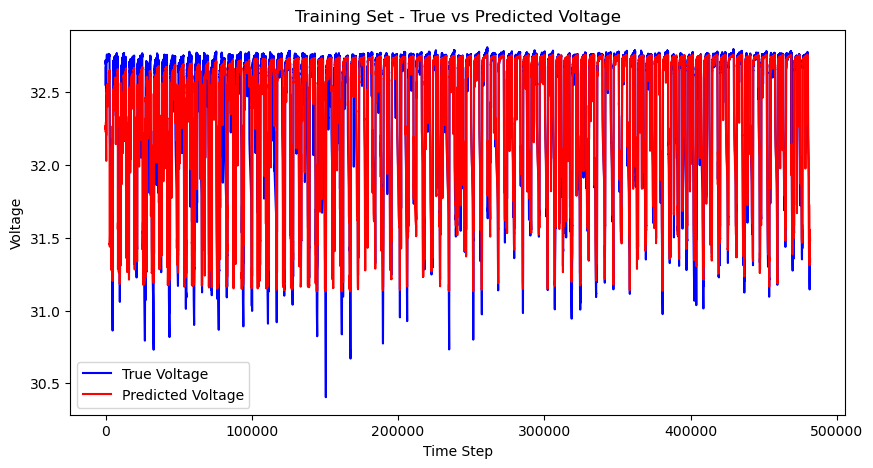

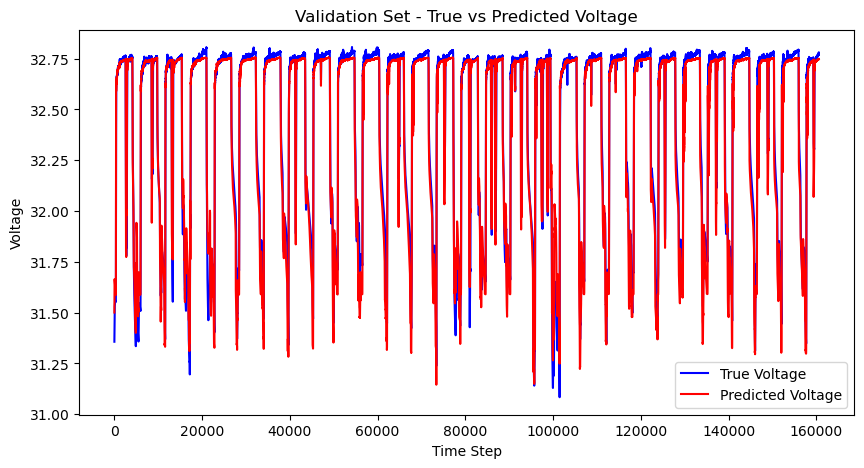

In [ ]:
def plot_predictions(true_values, predicted_values, time_steps, dataset_type="Training", zoom=False, start_time=None, end_time=None):
    plt.figure(figsize=(10, 5))
    
    # Check if zooming is enabled
    if zoom and start_time is not None and end_time is not None:
        # Select indices within the specified time range
        mask = (time_steps >= start_time) & (time_steps <= end_time)
        time_steps = time_steps[mask]
        true_values = true_values[mask]
        predicted_values = predicted_values[mask]
    
    plt.plot(time_steps, true_values, color='blue', label='True Voltage')
    plt.plot(time_steps, predicted_values, color='red', label='Predicted Voltage')
    plt.title(f'{dataset_type} Set - True vs Predicted Voltage')
    plt.xlabel('Time Step')
    plt.ylabel('Voltage')
    plt.legend()
    plt.show()

# Reshape the input data
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_reshaped = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Make predictions
predicted_train = model.predict(X_train_reshaped, batch_size=32)
predicted_val = model.predict(X_val_reshaped, batch_size=32)

# Unscale the predictions and true values
dummy_array = np.zeros((len(y_train), len(features_to_scale)))
dummy_array[:, features_to_scale.index('Battery Voltage')] = y_train
true_train_unscaled = scaler.inverse_transform(dummy_array)[:, features_to_scale.index('Battery Voltage')]

dummy_array[:, features_to_scale.index('Battery Voltage')] = predicted_train.flatten()
pred_train_unscaled = scaler.inverse_transform(dummy_array)[:, features_to_scale.index('Battery Voltage')]

# Do the same for validation set
dummy_array = np.zeros((len(y_val), len(features_to_scale)))
dummy_array[:, features_to_scale.index('Battery Voltage')] = y_val
true_val_unscaled = scaler.inverse_transform(dummy_array)[:, features_to_scale.index('Battery Voltage')]

dummy_array[:, features_to_scale.index('Battery Voltage')] = predicted_val.flatten()
pred_val_unscaled = scaler.inverse_transform(dummy_array)[:, features_to_scale.index('Battery Voltage')]

# Plot with unscaled values
plot_predictions(true_train_unscaled, pred_train_unscaled, np.arange(len(y_train)), dataset_type="Training")
plot_predictions(true_val_unscaled, pred_val_unscaled, np.arange(len(y_val)), dataset_type="Validation")

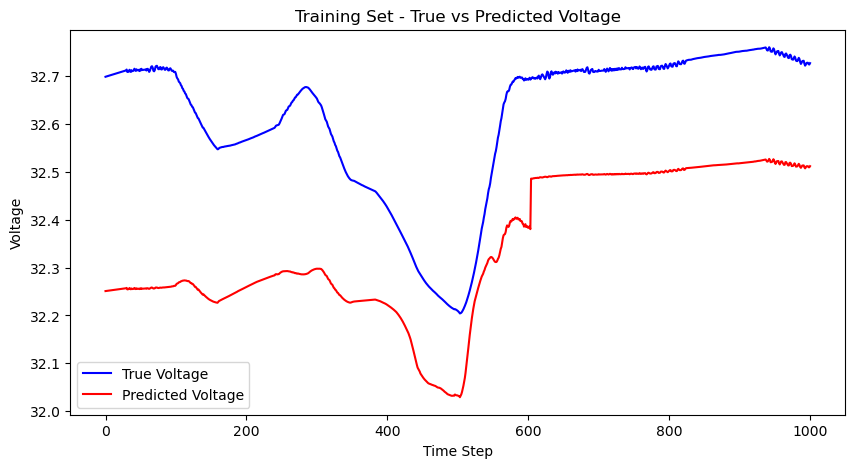

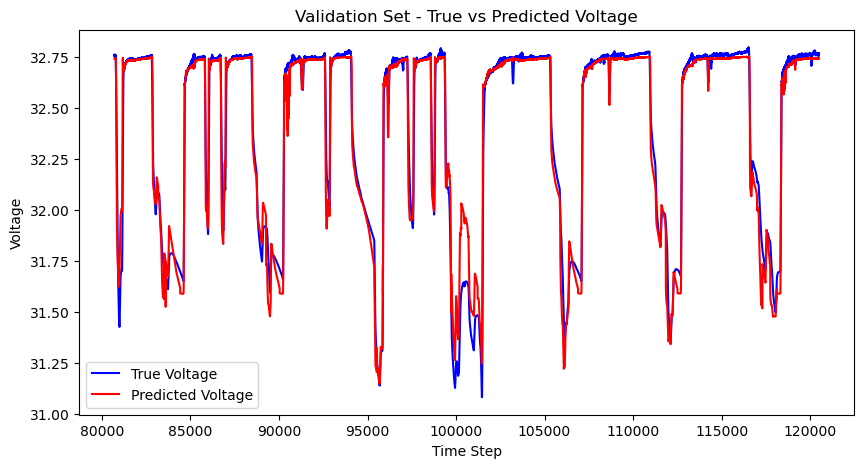

In [ ]:
plot_predictions(true_train_unscaled, pred_train_unscaled, np.arange(len(y_train)), dataset_type="Training", zoom=True, start_time=0, end_time=1000)
plot_predictions(true_val_unscaled, pred_val_unscaled, np.arange(len(y_val)), dataset_type="Validation", zoom=True, start_time=80700, end_time=120500)